In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
from pyinstrument import Profiler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import os
sys.path.append(os.path.dirname(os.getcwd()))
from bart_playground import *

import bartz

Note: In this branch, the special moves perform MCMC based on the priors (tree number prior and tree structure prior) without considering the likelihood. 
In contrast, the default moves follow standard MCMC, which includes the likelihood.

## Birth and Death only

In [2]:
proposal_probs = {"grow" : 0.5, "prune" : 0.5}
special_probs = {"birth": 0.5, "death": 0.5}
generator = DataGenerator(n_samples=160, n_features=2, noise=0.1, random_seed=42)
X, y = generator.generate(scenario="piecewise_flat")
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [3]:
bart = ChangeNumTreeBART(ndpost=1000, nskip=0, n_trees=1, 
                         proposal_probs=proposal_probs, special_probs = special_probs, 
                         theta_0 = 200, theta_df = np.inf, 
                         tree_num_prior_type="bernoulli")
bart.fit(X_train, y_train)

Iterations: 100%|██████████| 1000/1000 [00:12<00:00, 80.35it/s]


In [5]:
bart.trace[-1].n_trees

2

In [6]:
# Extract the n_trees value for each instance
n_trees_list = [instance.n_trees for instance in bart.trace]
np.mean(n_trees_list)

1.956043956043956

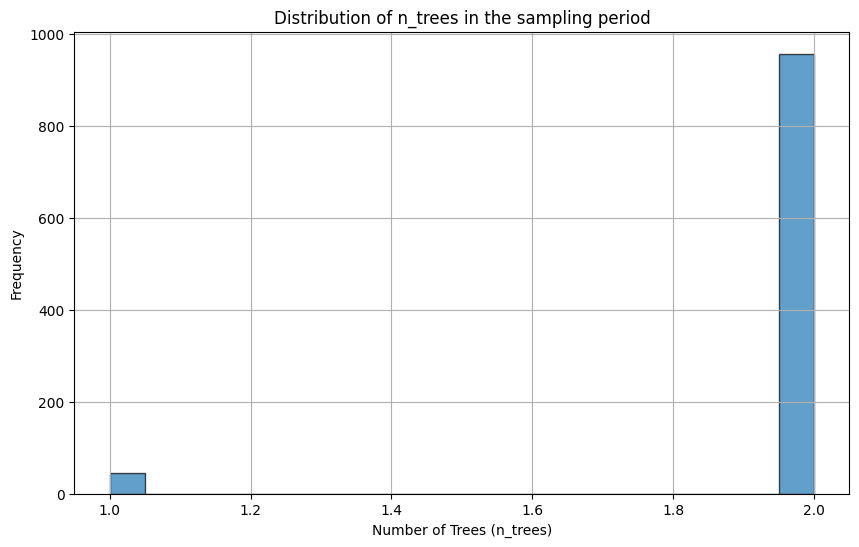

In [7]:
# Create a histogram with bins for each integer value
plt.figure(figsize=(10, 6))
plt.hist(n_trees_list, bins=20, edgecolor='k', alpha=0.7)
plt.title('Distribution of n_trees in the sampling period')
plt.xlabel('Number of Trees (n_trees)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

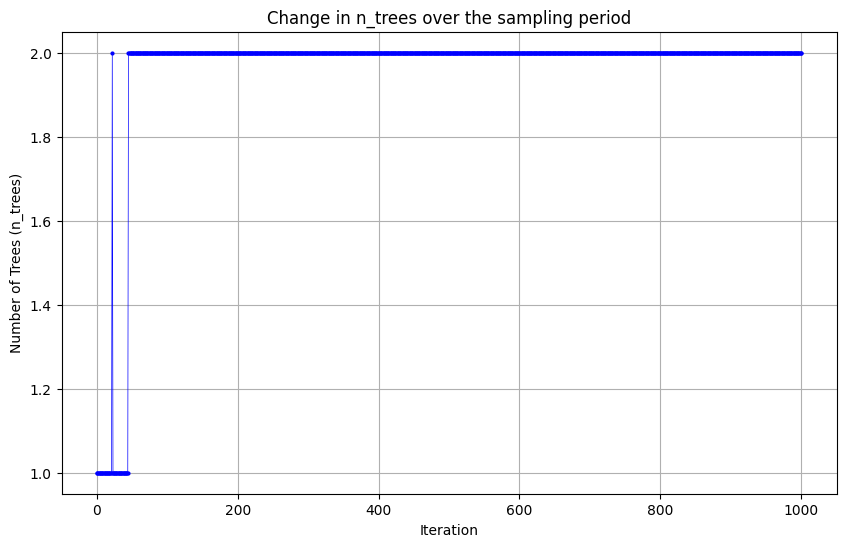

In [8]:
# Create a line plot
plt.figure(figsize=(10, 6))
plt.plot(
    range(len(n_trees_list)), 
    n_trees_list, 
    marker='o', 
    markersize=2,  # Adjust marker size
    linestyle='-', 
    linewidth=0.5,  # Adjust line width
    color='b'
)
plt.title('Change in n_trees over the sampling period')
plt.xlabel('Iteration')
plt.ylabel('Number of Trees (n_trees)')
plt.grid(True)
plt.show()

In [9]:
ntree = bart.trace[-1].n_trees
rf = RandomForestRegressor(n_estimators=ntree)
lr = LinearRegression()
rf.fit(X_train, y_train)
lr.fit(X_train, y_train)

btz = bartz.BART.gbart(np.transpose(X_train), y_train, ntree=ntree, ndpost=200, nskip=100)
btpred_all = btz.predict(np.transpose(X_test))
btpred = np.mean(np.array(btpred_all), axis=0)

INFO:2025-04-03 19:42:12,477:jax._src.xla_bridge:927: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:2025-04-03 19:42:12,481:jax._src.xla_bridge:927: Unable to initialize backend 'tpu': UNIMPLEMENTED: LoadPjrtPlugin is not implemented on windows yet.
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': UNIMPLEMENTED: LoadPjrtPlugin is not implemented on windows yet.


Iteration 100/300 P_grow=0.00 P_prune=1.00 A_grow=nan A_prune=0.50 (burnin)
Iteration 200/300 P_grow=0.50 P_prune=0.50 A_grow=0.00 A_prune=0.00
Iteration 300/300 P_grow=0.00 P_prune=1.00 A_grow=nan A_prune=0.00


In [10]:
models = {"bart" : bart, 
          "rf" : rf, 
          "lr" : lr,
          "btz" : btz}
results = {}
for model_name, model in models.items():
    if model_name == "btz":
        results[model_name] = mean_squared_error(y_test, btpred)
    else:
        results[model_name] = mean_squared_error(y_test, model.predict(X_test))
results

{'bart': 0.5501880276853189,
 'rf': 0.0419504086160613,
 'lr': 0.048045521328019404,
 'btz': 0.031405507956514866}

## Birth and Death only; Roots only (no grow)

In [11]:
proposal_probs = {"prune" : 1}
special_probs = {"birth": 0.5, "death": 0.5}
generator = DataGenerator(n_samples=160, n_features=2, noise=0.1, random_seed=42)
X, y = generator.generate(scenario="piecewise_flat")
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [12]:
bart = ChangeNumTreeBART(ndpost=1000, nskip=0, n_trees=1, 
                         proposal_probs=proposal_probs, special_probs = special_probs, 
                         theta_0 = 200, theta_df = np.inf, 
                         tree_num_prior_type="bernoulli")
bart.fit(X_train, y_train)

Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 3002.84it/s]


In [13]:
bart.trace[-1].n_trees

1

In [14]:
# Extract the n_trees value for each instance
n_trees_list = [instance.n_trees for instance in bart.trace]
np.mean(n_trees_list)

1.040959040959041

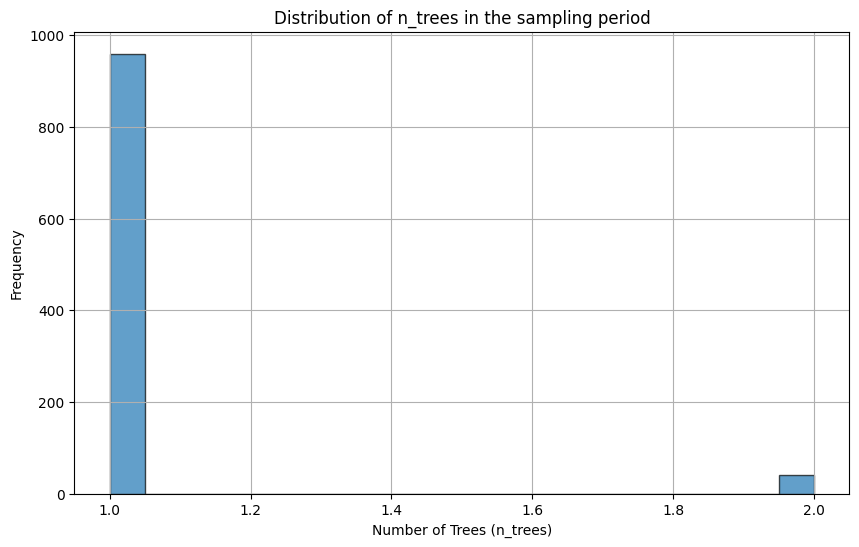

In [15]:
# Create a histogram with bins for each integer value
plt.figure(figsize=(10, 6))
plt.hist(n_trees_list, bins=20, edgecolor='k', alpha=0.7)
plt.title('Distribution of n_trees in the sampling period')
plt.xlabel('Number of Trees (n_trees)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

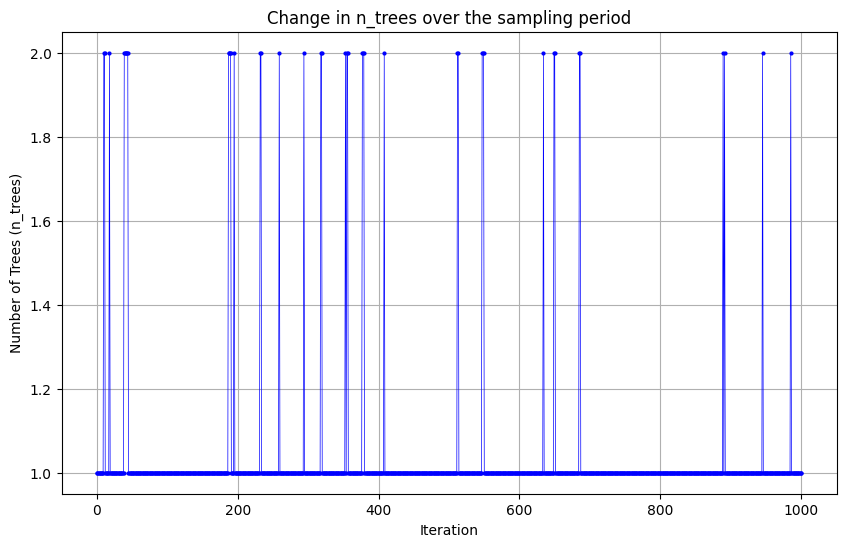

In [16]:
# Create a line plot
plt.figure(figsize=(10, 6))
plt.plot(
    range(len(n_trees_list)), 
    n_trees_list, 
    marker='o', 
    markersize=2,  # Adjust marker size
    linestyle='-', 
    linewidth=0.5,  # Adjust line width
    color='b'
)
plt.title('Change in n_trees over the sampling period')
plt.xlabel('Iteration')
plt.ylabel('Number of Trees (n_trees)')
plt.grid(True)
plt.show()

In [17]:
ntree = bart.trace[-1].n_trees
rf = RandomForestRegressor(n_estimators=ntree)
lr = LinearRegression()
rf.fit(X_train, y_train)
lr.fit(X_train, y_train)

btz = bartz.BART.gbart(np.transpose(X_train), y_train, ntree=ntree, ndpost=200, nskip=100)
btpred_all = btz.predict(np.transpose(X_test))
btpred = np.mean(np.array(btpred_all), axis=0)

Iteration 100/300 P_grow=1.00 P_prune=0.00 A_grow=0.00 A_prune=nan (burnin)
Iteration 200/300 P_grow=1.00 P_prune=0.00 A_grow=0.00 A_prune=nan
Iteration 300/300 P_grow=0.00 P_prune=1.00 A_grow=nan A_prune=0.00


In [18]:
models = {"bart" : bart, 
          "rf" : rf, 
          "lr" : lr,
          "btz" : btz}
results = {}
for model_name, model in models.items():
    if model_name == "btz":
        results[model_name] = mean_squared_error(y_test, btpred)
    else:
        results[model_name] = mean_squared_error(y_test, model.predict(X_test))
results

{'bart': 0.10538721598089913,
 'rf': 0.0607639201256132,
 'lr': 0.048045521328019404,
 'btz': 0.03915003274101436}